In [1]:
import sys
import os
sys.path.append(os.path.abspath("/Users/taylorjones/.pyenv/versions/2.7.17/lib/python2.7/site-packages"))

# Enable in-line plots
%matplotlib inline

# Tab complete
%config IPCompleter.greedy=True

# Load libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import multiprocessing
import gffutils
from pybedtools import BedTool
import metaseq
from gffutils.helpers import asinterval
import seaborn as sns

In [2]:
window=2000
bin_size=window/20 #inverse

rootdir = '/Users/taylorjones/Desktop/peptide_metagene_and_stats/'
gtfs = rootdir+'gtfs/'
os.system('mkdir -p '+gtfs)
bws = rootdir+'bigwigs/chipin/'

p53df=pd.read_csv(rootdir+'p53_target_andrysik2018.txt', sep='\t', header=None)
p53_list=list(p53df[0])

In [4]:
#################### ChIP DATA #############################################

DW_signal = metaseq.genomic_signal(
    os.path.join(bws, 'DMSO_average.bw'),
    'bigwig')


DP_signal = metaseq.genomic_signal(
    os.path.join(bws, 'DMSO_pep_R2.bw'),
    'bigwig')


NW_signal = metaseq.genomic_signal(
    os.path.join(bws, 'Nutlin_average.bw'),
    'bigwig')


NP_signal = metaseq.genomic_signal(
    os.path.join(bws, 'Nutlin_pep_R2.bw'),
    'bigwig')

# p53

In [7]:
annotation = 'tss_adjusted_counts'
df = pd.read_csv(rootdir + annotation+'.txt', sep='\t')
adj_count_names = ['chr','start','stop','accession']
count_names= ['DMSO_R1','DMSO_R2','DMSO_pep_R2',
        'Nutlin_R1','Nutlin_R2','Nutlin_pep_R2']
for i in count_names:
    adj_count_names.append(i+'_applied_ratio')
df=df[adj_count_names]


df_cut = df.accession.str.split("_", expand=True,)
df_cut = df_cut[[2]]
df_cut.columns = ['gene']
df = df.merge(df_cut,  left_index=True, right_index=True)
df=df[df['gene'].isin(p53_list)]
# df=df[['chr', 'start', 'stop', 'accession']]
df['Nutlin_applied_ratio']  = (df['Nutlin_R1_applied_ratio'] + df['Nutlin_R2_applied_ratio'])/2
df = df[df['Nutlin_applied_ratio']>df['Nutlin_pep_R2_applied_ratio']]
df['source']=1
df['feature']='tss'
df['score']=1
df['strand']='-'
df['frame']='1'
df['attribute']='this;tss'

df['start_center'] = df['start'] + ((df['stop'] - df['start']) / 2)
df['stop_center'] = (df['stop'] - ((df['stop'] - df['start']) / 2))
df=df.sort_values(by=['chr','start'])
# df
# df.to_csv(rootdir+'p53_target_genes_counts.txt',sep='\t',index=False)
df = df.astype({'start_center': 'int32', 'stop_center': 'int32'}).drop(columns=['start','stop'])
center_df= df[['chr', 'source', 'feature', 'start_center', 'stop_center', 'score', 'strand', 'frame', 'attribute']]

df['start'] = df['start_center'] - window
df['stop'] = df['stop_center'] + window
# 
df = df[['chr', 'source', 'feature', 'start', 'stop', 'score', 'strand', 'frame', 'attribute']]
df = df[df['start'] >= 0]
df
len(center_df)

70

In [9]:
# Use all available cpus -- this can also be hard set (i.e. as an integer value)
processes = multiprocessing.cpu_count()

# # # Define our regions file (gtf) and load as a pandas dataframe
# center_df = pd.read_csv(gtfs + annotation +'_centered.gtf', sep='\t', header=None, \
#                 names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes'])

center = BedTool.from_dataframe(center_df)

# regions_df = pd.read_csv(gtfs + annotation +str(window) +'bp_centered.gtf', sep='\t', header=None, \
#                 names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes'])

regions = BedTool.from_dataframe(df)

# ChIPseq signal files
DW_array = DW_signal.array(regions,
   bins=bin_size,
   processes=processes)

DP_array = DP_signal.array(regions,
   bins=bin_size,
   processes=processes)

NW_array = NW_signal.array(regions,
   bins=bin_size,
   processes=processes)

NP_array = NP_signal.array(regions,
   bins=bin_size,
   processes=processes)

# Cache to disk. The data will be saved as "example.npz" and "example.features".
metaseq.persistence.save_features_and_arrays(
   features=center,
   arrays={'DMSO': DW_array,
           'DMSO Peptide': DP_array,
           'Nutlin': NW_array,
           'Nutlin Peptide': NP_array},
   prefix='p53_chip_signal_' +str(window) + '_'+annotation,
   link_features=True,
   overwrite=True)
#
print('Finished')
features, p53_arrays = metaseq.persistence.load_features_and_arrays(prefix= 'p53_chip_signal_' +str(window) + '_'+annotation)

Finished


# Plotting

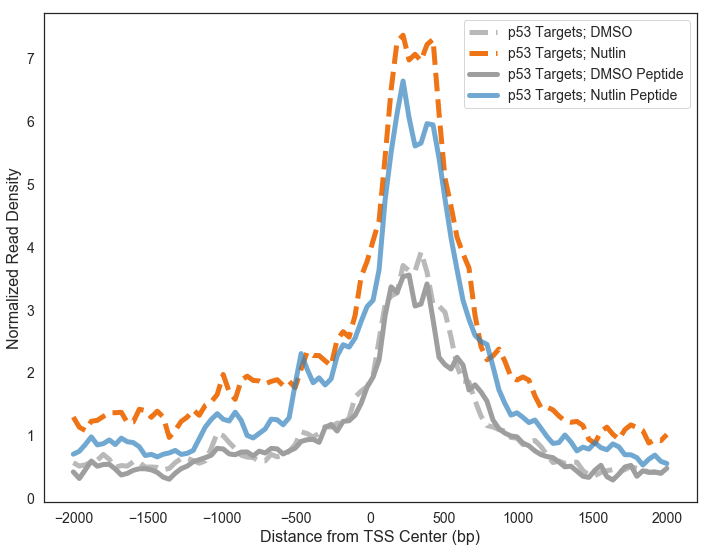

In [11]:
x = np.linspace(-window, window, bin_size)
# Create a figure and axes
fig = plt.figure()
ax = fig.add_subplot(111)

lnwd = 5


############# ChIP Data ########################## normalize ChIP data
ax.plot(
   x,
   (p53_arrays['DMSO']).mean(axis=0),
   color='#b9b9b9',
   label='p53 Targets; DMSO', linewidth=lnwd, linestyle='--')

ax.plot(
   x,
   (p53_arrays['Nutlin']).mean(axis=0),
   color='#EE7416',
   label='p53 Targets; Nutlin', linewidth=lnwd, linestyle='--') ##orange

ax.plot(
   x,
   (p53_arrays['DMSO Peptide']).mean(axis=0),
   color='#9E9E9E',
   label='p53 Targets; DMSO Peptide', linewidth=lnwd)

ax.plot(
   x,
   (p53_arrays['Nutlin Peptide']).mean(axis=0),
   color='#3484BF',
   label='p53 Targets; Nutlin Peptide', linewidth=lnwd, alpha=0.7)  ##blue


# Add labels and legend
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

ax.set_xlabel('Distance from TSS Center (bp)')
ax.set_ylabel('Normalized Read Density')
sns.set(rc={'figure.figsize':(11.7,9)})
sns.set_style("white")
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plt.ylim(-0.1, 0.4)
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend(loc='best');

# #filename = '41_chip_peaks_motif_only_1hr_vs_6hr'
plt.savefig(rootdir + 'UPp53_nutav_dmsor2_nutpepR2_'+str(window)+'_' + annotation + '.svg')
plt.savefig(rootdir + 'UPp53_nutav_dmsor2_nutpepR2_'+str(window)+'_' + annotation + '.png')